# Multi-Dataset ImageNet Training with ResNet50 - Modular Version

This notebook demonstrates training ResNet50 on multiple ImageNet variants using a modular approach. The code supports experiments across different datasets for comprehensive analysis.

## Supported Datasets:
- **ImageNette**: 10 classes, 224x224 images (fastest for experiments)
- **Tiny ImageNet**: 200 classes, 64x64 images (medium complexity)
- **ImageNet Mini**: 1000 classes, 224x224 images (subset of full ImageNet)
- **Full ImageNet**: 1000 classes, 224x224 images (full dataset)

## Features:
- **Modular Design**: Separate modules for configuration, data loading, models, and training utilities
- **Multi-Dataset Support**: Easy switching between different ImageNet variants
- **Dataset-Specific Training**: Optimized hyperparameters for each dataset
- **Comprehensive Metrics**: Tracks training and validation metrics
- **Model Saving**: Automatic model checkpointing with dataset-specific naming


In [ ]:
# Install required packages
%pip install torchsummary albumentations


In [ ]:
# Step 1: Clone the repo
!rmdir ERAv4S9
!git clone https://github.com/nitin-vig/ERAv4S9.git

# Step 2: Move into the repo folder
%cd ERAv4S9

# Step 3: (Optional) List files to verify
!ls -l

rmdir: failed to remove 'ERAv4S9': No such file or directory
Cloning into 'ERAv4S9'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 26), reused 40 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 174.58 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/ERAv4S9/ERAv4S9
total 224
-rw-r--r-- 1 root root 20980 Oct 26 06:28 advanced_optimizer_scheduler.py
-rw-r--r-- 1 root root 12955 Oct 26 06:28 config.py
-rw-r--r-- 1 root root 23732 Oct 26 06:28 dataset_loader.py
-rw-r--r-- 1 root root 22334 Oct 26 06:28 enhanced_progressive_training.py
-rw-r--r-- 1 root root  7974 Oct 26 06:28 example_usage.py
-rw-r--r-- 1 root root 34154 Oct 26 06:28 ImageNet_Experiment_Resnet_50.ipynb
-rw-r--r-- 1 root root  6901 Oct 26 06:28 models.py
-rw-r--r-- 1 root root 25541 Oct 26 06:28 progressive_training_strategy.py
-rw-r--r-- 1 root root 10776 Oct 26 06:28 R

In [ ]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

# Import our modular components
from config import Config
from dataset_loader import get_data_loaders, visualize_samples
from models import get_model, count_parameters, get_model_summary, save_model
from training_utils import train_model, train_model_with_transfer, evaluate_model, MetricsTracker

print(Config.__dict__)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


{'__module__': 'config', '__doc__': 'Configuration class for progressive training strategy', 'DEVICE': 'cpu', 'DATA_ROOT': '/content/data', 'SAVE_DIR': './progressive_models', 'SAVE_MODEL_PATH': './models', 'MODEL_NAME': 'resnet50', 'MOUNT_DRIVE': False, 'DRIVE_MODEL_PATH': '/content/drive/MyDrive/models', 'STAGES': {'imagenette': {'dataset': 'imagenette', 'classes': 10, 'image_size': 224, 'epochs': 20, 'batch_size': 64, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Quick warmup and architecture validation', 'enabled': True, 'priority': 1}, 'tiny_imagenet': {'dataset': 'tiny_imagenet', 'classes': 200, 'image_size': 64, 'epochs': 30, 'batch_size': 128, 'lr': 0.0005, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Medium complexity training', 'enabled': True, 'priority': 2}, 'imagenet_mini': {'dataset': 'imagenet_mini', 'classes': 1000, 'image_size': 22

## Configuration

Let's configure our training parameters. You can easily switch between datasets and modify training parameters here.


In [ ]:
# Configuration setup for multi-dataset experiments
# You can easily switch between datasets by changing DATASET_NAME

# Dataset configuration
DATASET_NAME = "imagenette"  # Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
USE_PRETRAINED = False  # Custom implementation without pretrained weights

# Update configuration for the selected dataset
Config.update_for_dataset(DATASET_NAME)

print("Configuration updated!")
print(f"Dataset: {DATASET_NAME}")
print(f"Image size: {Config.IMAGE_SIZE}")
print(f"Number of classes: {Config.NUM_CLASSES}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Use pretrained: {USE_PRETRAINED}")

# Display dataset-specific training parameters
dataset_config = Config.get_dataset_config()
print(f"\nDataset-specific parameters:")
print(f"Optimizer: {dataset_config['optimizer']}")
print(f"Scheduler: {dataset_config['scheduler']}")


Configuration updated for imagenette
Image size: 224
Number of classes: 10
Batch size: 64
Epochs: 20
Learning rate: 0.001
Configuration updated!
Dataset: imagenette
Image size: 224
Number of classes: 10
Batch size: 64
Epochs: 20
Learning rate: 0.001
Use pretrained: False

Dataset-specific parameters:
Optimizer: adamw
Scheduler: cosine


## Environment Setup

Setup the environment and check GPU availability. For full ImageNet training, you'll need significant computational resources.


In [ ]:
# Setup environment
def setup_environment():
    """Setup environment for ImageNet training"""
    print("Setting up environment for ImageNet training...")

    # Create necessary directories
    os.makedirs(Config.DATA_ROOT, exist_ok=True)
    os.makedirs(Config.SAVE_MODEL_PATH, exist_ok=True)

    print("Environment setup complete!")

def check_gpu_availability():
    """Check GPU availability and setup device"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print("Warning: Full ImageNet training requires significant GPU memory!")
    else:
        print("Warning: CPU training will be very slow for ImageNet!")

    return device

# Run setup
setup_environment()
device = check_gpu_availability()

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Setting up environment for ImageNet training...
Environment setup complete!
Using device: cuda
GPU: NVIDIA L4
GPU Memory: 23.8 GB


In [ ]:
# 🧩 Colab Dataset Setup Cell
# Copy-paste this cell into your Colab notebook

import os
import subprocess

# Install required packages (if not already installed)
!pip install -q torch torchvision albumentations tqdm requests

DATA_DIR = "/content/data"
IMAGENETTE_DIR = os.path.join(DATA_DIR, "imagenette2")
TINY_IMAGENET_DIR = os.path.join(DATA_DIR, "tiny-imagenet-200")

os.makedirs(DATA_DIR, exist_ok=True)

def run_cmd(cmd):
    """Helper to run shell commands cleanly."""
    result = subprocess.run(cmd, shell=True, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        print(f"⚠️ Warning: {cmd} failed with error:\n{result.stderr}")
    return result

# ------------------------------
# 🔹 Download ImageNette
# ------------------------------
if not os.path.exists(IMAGENETTE_DIR) or len(os.listdir(IMAGENETTE_DIR)) == 0:
    print("🔄 Downloading ImageNette...")
    run_cmd("wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz")
    run_cmd("tar -xzf imagenette2.tgz")
    run_cmd(f"mv imagenette2 {DATA_DIR}/")
    run_cmd("rm imagenette2.tgz")
    print("✅ ImageNette downloaded!")
else:
    print(f"✅ Skipping ImageNette — already exists at {IMAGENETTE_DIR}")

# ------------------------------
# 🔹 Download Tiny ImageNet
# ------------------------------
if not os.path.exists(TINY_IMAGENET_DIR) or len(os.listdir(TINY_IMAGENET_DIR)) == 0:
    print("🔄 Downloading Tiny ImageNet...")
    run_cmd("wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip")
    run_cmd("unzip -q tiny-imagenet-200.zip")
    run_cmd(f"mv tiny-imagenet-200 {DATA_DIR}/")
    run_cmd("rm tiny-imagenet-200.zip")
    print("✅ Tiny ImageNet downloaded!")
else:
    print(f"✅ Skipping Tiny ImageNet — already exists at {TINY_IMAGENET_DIR}")

# ------------------------------
# 🔹 Verify
# ------------------------------
print("\n📁 Dataset verification:")
!ls -la {DATA_DIR}
!du -sh {DATA_DIR}/* | sort -h

print("\n🎉 Datasets ready! You can now use:")
print("from dataloader import get_data_loaders")
print("train_loader, test_loader = get_data_loaders('imagenette')")


✅ Skipping ImageNette — already exists at /content/data/imagenette2
✅ Skipping Tiny ImageNet — already exists at /content/data/tiny-imagenet-200

📁 Dataset verification:
total 16
drwxr-xr-x 4 root root  4096 Oct 26 06:22 .
drwxr-xr-x 1 root root  4096 Oct 26 06:23 ..
drwxr-xr-x 4  501 staff 4096 Feb  6  2021 imagenette2
drwxrwxr-x 5 root root  4096 Feb  9  2015 tiny-imagenet-200
481M	/content/data/tiny-imagenet-200
1.5G	/content/data/imagenette2

🎉 Datasets ready! You can now use:
from dataloader import get_data_loaders
train_loader, test_loader = get_data_loaders('imagenette')


## Data Loading

Load the dataset and visualize some sample images.


Loading dataset...
Dataset: imagenette
Train samples: 9469
Test samples: 3925
Number of classes: 10

Visualizing sample images...


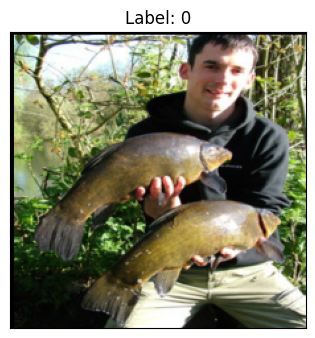

In [ ]:
# Load dataset
print("Loading dataset...")
train_loader, test_loader = get_data_loaders(DATASET_NAME)

# Visualize some samples
print("\nVisualizing sample images...")
visualize_samples(train_loader, num_samples=12)


In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/gdrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model Creation

Create the ResNet50 model and display its architecture.


In [ ]:
# Create model
print(f"Creating {Config.MODEL_NAME} model...")
model = get_model(
    model_name=Config.MODEL_NAME,
    dataset_name=DATASET_NAME,
    pretrained=USE_PRETRAINED
)

# Move model to device
model = model.to(device)

# Print model info
print(f"Model parameters: {count_parameters(model):,}")

# Get model summary
dataset_config = Config.get_dataset_config()
input_size = (3, dataset_config["image_size"], dataset_config["image_size"])
print(f"\nModel summary (input size: {input_size}):")
get_model_summary(model, input_size=input_size)


Creating resnet50 model...
Model parameters: 23,528,522

Model summary (input size: (3, 224, 224)):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
   

## Training

Train the model using our modular training utilities.


In [ ]:
# Train model
stage_config = Config.STAGES[DATASET_NAME]
print(stage_config)
NUM_EPOCHS = stage_config["epochs"]
BATCH_SIZE = stage_config["batch_size"]
LEARNING_RATE = stage_config["lr"]
WEIGHT_DECAY = stage_config["weight_decay"]

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")

metrics_tracker = train_model(model, train_loader, test_loader, device, Config)


{'dataset': 'imagenette', 'classes': 10, 'image_size': 224, 'epochs': 20, 'batch_size': 64, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Quick warmup and architecture validation', 'enabled': True, 'priority': 1}
Starting training for 20 epochs...
Batch size: 64
Learning rate: 0.001
Weight decay: 0.0001


AttributeError: type object 'ProgressiveConfig' has no attribute 'SCHEDULER_PATIENCE'

## Results Visualization

Plot the training metrics and evaluate the final model.


In [ ]:
# Plot training metrics
print("Plotting training metrics...")
metrics_tracker.plot_metrics(save_path=f"{Config.SAVE_MODEL_PATH}/training_metrics.png")

# Final evaluation
print("\nFinal evaluation...")
test_loss, test_acc, test_top5_acc = evaluate_model(model, test_loader, device)

print(f"\nTraining completed!")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Top-5 Accuracy: {test_top5_acc:.2f}%")


## Model Saving

Save the trained model to local storage and Google Drive.


In [ ]:
# Save final model
final_model_path = f"{Config.SAVE_MODEL_PATH}/final_model.pth"
save_model(model, final_model_path, epoch=NUM_EPOCHS, loss=test_loss)

# Save to Google Drive if mounted
if Config.MOUNT_DRIVE:
    drive_model_path = f"{Config.DRIVE_MODEL_PATH}/final_model.pth"
    save_model(model, drive_model_path, epoch=NUM_EPOCHS, loss=test_loss)
    print(f"Model also saved to Google Drive: {drive_model_path}")

print("Model saving completed!")


## Progressive Transfer Learning (Multi-Stage Training)

Run multiple stages in sequence with automatic weight transfer from each stage to the next.


In [ ]:
"""
PROGRESSIVE TRANSFER LEARNING - RUN SELECTED STAGES
===================================================
Train multiple stages in sequence with automatic weight transfer.
"""

import json
from datetime import datetime

# ⚙️ CONFIGURATION - Choose which stages to run
# ================================================
STAGES_TO_RUN = ["imagenette", "tiny_imagenet"]  # Modify this list
# Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
# Order matters! Stages run in sequence with weight transfer

USE_PRETRAINED_FOR_FIRST_STAGE = False  # Start with ImageNet pretrained weights?
SAVE_RESULTS_AT_EACH_STAGE = True  # Save models and metrics at each stage?

# Results storage
all_stage_results = {}
pretrained_weights_path = None

print("🚀 Progressive Transfer Learning Training")
print(f"Stages to run: {STAGES_TO_RUN}")
print(f"Start with pretrained: {USE_PRETRAINED_FOR_FIRST_STAGE}")
print(f"Save at each stage: {SAVE_RESULTS_AT_EACH_STAGE}")
print("="*80)

for i, stage_name in enumerate(STAGES_TO_RUN, 1):
    print(f"\n{'='*80}")
    print(f"STAGE {i}/{len(STAGES_TO_RUN)}: {stage_name.upper()}")
    print(f"{'='*80}")

    # Update configuration for this stage
    Config.update_for_dataset(stage_name)

    # Get stage configuration
    stage_config = Config.STAGES[stage_name]
    print(f"Classes: {stage_config['classes']}")
    print(f"Image size: {stage_config['image_size']}")
    print(f"Epochs: {stage_config['epochs']}")
    print(f"Batch size: {stage_config['batch_size']}")
    print(f"LR: {stage_config['lr']}")
    print(f"Previous weights: {pretrained_weights_path or 'None (fresh start)'}")

    # Load dataset
    print(f"\n📦 Loading {stage_name} dataset...")
    train_loader, test_loader = get_data_loaders(stage_name)

    # Create model
    print(f"\n🧠 Creating model for {stage_name}...")
    use_pretrained = USE_PRETRAINED_FOR_FIRST_STAGE if (i == 1 and not pretrained_weights_path) else False
    model = get_model(
        model_name=Config.MODEL_NAME,
        dataset_name=stage_name,
        pretrained=use_pretrained
    )
    model = model.to(device)
    print(f"Model created: {count_parameters(model):,} parameters")

    # Determine next stage name for weight saving
    next_stage = STAGES_TO_RUN[i] if i < len(STAGES_TO_RUN) else None

    # Train with transfer learning
    print(f"\n🏋️ Training {stage_name}...")
    metrics_tracker, final_weights = train_model_with_transfer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        config=Config,
        pretrained_weights_path=pretrained_weights_path,
        next_stage_name=next_stage
    )

    # Save results if requested
    if SAVE_RESULTS_AT_EACH_STAGE:
        stage_save_dir = f"{Config.SAVE_MODEL_PATH}/{stage_name}_stage_{i}"
        os.makedirs(stage_save_dir, exist_ok=True)

        # Save final model
        final_model_path = f"{stage_save_dir}/final_model.pth"
        torch.save(model.state_dict(), final_model_path)
        print(f"✅ Saved model: {final_model_path}")

        # Save metrics
        metrics_data = {
            "stage": stage_name,
            "stage_number": i,
            "final_train_loss": metrics_tracker.train_losses[-1] if metrics_tracker.train_losses else None,
            "final_train_acc": metrics_tracker.train_acc[-1] if metrics_tracker.train_acc else None,
            "final_test_loss": metrics_tracker.test_losses[-1] if metrics_tracker.test_losses else None,
            "final_test_acc": metrics_tracker.test_acc[-1] if metrics_tracker.test_acc else None,
            "config": stage_config
        }

        metrics_path = f"{stage_save_dir}/metrics.json"
        with open(metrics_path, 'w') as f:
            json.dump(metrics_data, f, indent=2)
        print(f"✅ Saved metrics: {metrics_path}")

        # Save metrics plot (graph with training curves)
        plot_path = f"{stage_save_dir}/training_metrics.png"
        metrics_tracker.plot_metrics(save_path=plot_path)
        print(f"✅ Saved training graphs: {plot_path}")

        all_stage_results[stage_name] = {
            "metrics": metrics_data,
            "model_path": final_model_path,
            "plot_path": plot_path
        }

    # Set weights path for next stage
    if next_stage:
        pretrained_weights_path = f"{Config.SAVE_MODEL_PATH}/weights_for_{next_stage}.pth"

    print(f"\n✅ Stage {i} completed!")
    print("-"*80)

# Final summary
print("\n" + "="*80)
print("🎉 ALL STAGES COMPLETE!")
print("="*80)
if SAVE_RESULTS_AT_EACH_STAGE:
    print("\n📊 Results Summary:")
    print(f"{'Stage':<20} {'Test Accuracy':<15} {'Graph Location':<50}")
    print("-"*90)
    for stage_name, result in all_stage_results.items():
        final_test_acc = result['metrics'].get('final_test_acc', 'N/A')
        plot_path = result.get('plot_path', 'N/A')
        if isinstance(final_test_acc, (int, float)):
            print(f"{stage_name:<20} {final_test_acc:<15.2f} {plot_path}")
        else:
            print(f"{stage_name:<20} {str(final_test_acc):<15} {plot_path}")
    print(f"\n📁 All results saved in: {Config.SAVE_MODEL_PATH}")
    print(f"📈 Training graphs (training_metrics.png) saved for each stage!")
